# Imports

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
%matplotlib inline
from datetime import datetime
from catboost import CatBoostRegressor


In [3]:
from Wind.dataset import Dataset
from Wind.utils import experiment_results
from Wind.model import *

In [4]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [5]:

# Change directory to the dataset
train_csv_1= 'datasets/UK/Turbine_Data_Kelmarsh_2_2018-01-01_-_2019-01-01_229.csv'
train_csv_2 = 'datasets/UK/Turbine_Data_Kelmarsh_2_2019-01-01_-_2020-01-01_229.csv'
val_csv = 'datasets/UK/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv'
test_csv = 'datasets/UK/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv'

csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9} # This part is copied from data provider check references

train_1 = pd.read_csv(train_csv_1,**csv_params)
train_2 = pd.read_csv(train_csv_2,**csv_params)
val = pd.read_csv(val_csv,**csv_params)
test = pd.read_csv(test_csv,**csv_params) #



concatenated_df = pd.concat([train_1,train_2,val,test]) # Concatanate test and train data
test_dates = concatenated_df[concatenated_df.index >= '2020-07-01'] # change test set to given test set
val_dates = concatenated_df[ (concatenated_df.index >= '2019-07-01') & (concatenated_df.index < '2020-07-01') ]


val_split = len(val_dates)/len(concatenated_df)
test_split = len(test_dates)/len(concatenated_df)

In [6]:
# This part is also copied from data provider, fields look good in terms of statistics
use_columns = [ 'Wind speed (m/s)','Wind speed, Standard deviation (m/s)', 'Wind speed, Minimum (m/s)',
            'Wind speed, Maximum (m/s)','Wind direction (°)','Nacelle position (°)','Energy Export (kWh)','Power (kW)',
            'Reactive power (kvar)','Rotor speed (RPM)','Generator RPM (RPM)','Nacelle ambient temperature (°C)',
            'Blade angle (pitch position) A (°)','Blade angle (pitch position) B (°)','Blade angle (pitch position) C (°)',
            'Lost Production to Curtailment (Total) (kWh)','Lost Production to Downtime (kWh)','Metal particle count counter',
            'Front bearing temperature (°C)','Rear bearing temperature (°C)']

In [7]:
roll_window = 4
dataset = Dataset(concatenated_df[use_columns])
dataset.fill_nan(use_columns)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
# Rolling means selected heuristicly
dataset.apply_rolling_window(dataset.df,'Wind speed (m/s)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Nacelle ambient temperature (°C)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Generator RPM (RPM)' , roll_window,np.mean)

# One-Shot Modelling

## Next Step Prediction

### Default

In [8]:
horizon = 1
window = 144

train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,target_col = 'Power (kW)',test_split= test_split,val_split = val_split,shuffle = True)

In [9]:
model = Model('cb',{'thread_count':4,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.099478
0:	learn: 609.3350333	test: 608.6268044	best: 608.6268044 (0)	total: 7.43ms	remaining: 7.42s
500:	learn: 132.2512832	test: 144.1163717	best: 144.1161612 (499)	total: 2.58s	remaining: 2.57s
999:	learn: 123.3150610	test: 143.7476914	best: 143.7468302 (998)	total: 5.03s	remaining: 0us
bestTest = 143.7468302
bestIteration = 998
Shrink model to first 999 iterations.


                  MAE        RMSE        R2
Validation  91.558098  143.746834  0.953936
Test        90.097491  140.367442  0.956138


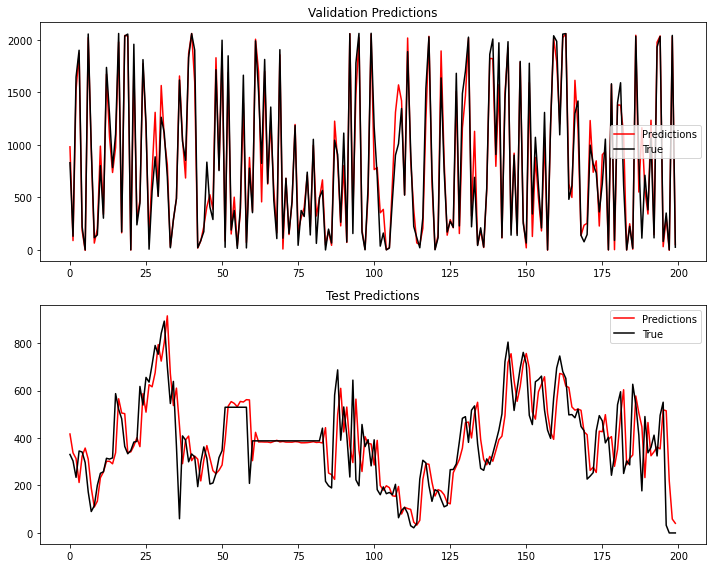

In [10]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



### Feat Select



In [11]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y,num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [12]:
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.099478
0:	learn: 609.0986251	test: 608.3084951	best: 608.3084951 (0)	total: 4.59ms	remaining: 4.58s
500:	learn: 131.1479922	test: 143.1375721	best: 143.1277786 (494)	total: 1.52s	remaining: 1.51s
999:	learn: 122.0618621	test: 142.9157086	best: 142.8654348 (870)	total: 2.99s	remaining: 0us
bestTest = 142.8654348
bestIteration = 870
Shrink model to first 871 iterations.


                  MAE        RMSE        R2
Validation  90.713801  142.865440  0.954499
Test        89.635060  139.824998  0.956476


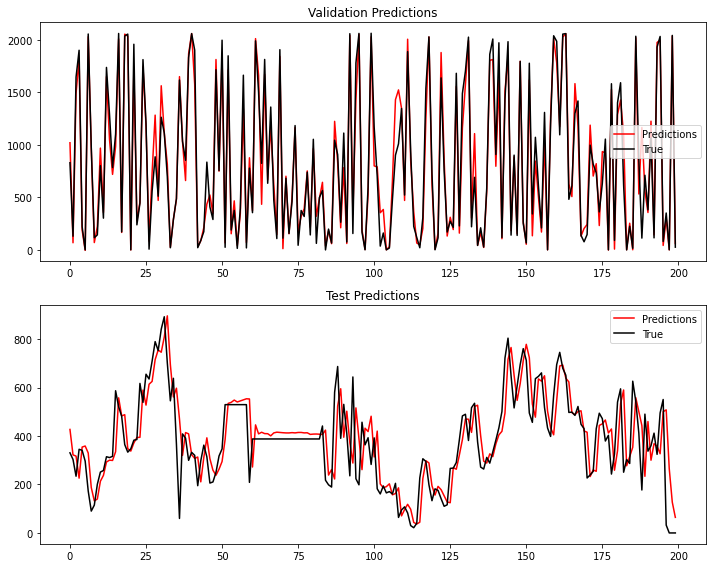

In [13]:
next_step_os_feat,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



### Hyp-op



In [14]:
model.hyp_op(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y, task_type = 'GPU')

[I 2023-09-02 21:26:54,334] A new study created in memory with name: no-name-8362572f-5d5b-4f63-8824-00d1e5728302
[I 2023-09-02 21:27:02,330] Trial 0 finished with value: 92.37591794293358 and parameters: {'learning_rate': 0.0073722134913948596, 'depth': 9, 'min_data_in_leaf': 33}. Best is trial 0 with value: 92.37591794293358.
[I 2023-09-02 21:27:04,224] Trial 1 finished with value: 106.50681172793384 and parameters: {'learning_rate': 0.003602960543771026, 'depth': 2, 'min_data_in_leaf': 72}. Best is trial 0 with value: 92.37591794293358.
[I 2023-09-02 21:27:07,867] Trial 2 finished with value: 140.44876098522823 and parameters: {'learning_rate': 0.0019664158811493982, 'depth': 6, 'min_data_in_leaf': 68}. Best is trial 0 with value: 92.37591794293358.
[I 2023-09-02 21:27:11,481] Trial 3 finished with value: 90.79915517235483 and parameters: {'learning_rate': 0.066387697142624, 'depth': 6, 'min_data_in_leaf': 84}. Best is trial 3 with value: 90.79915517235483.
[I 2023-09-02 21:27:15,03

Best hyperparameters: {'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64}
Best RMSE: 90.42992532293626


({'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},
 90.42992532293626)

                  MAE        RMSE        R2
Validation  90.579660  142.902429  0.954476
Test        89.587494  139.467410  0.956699


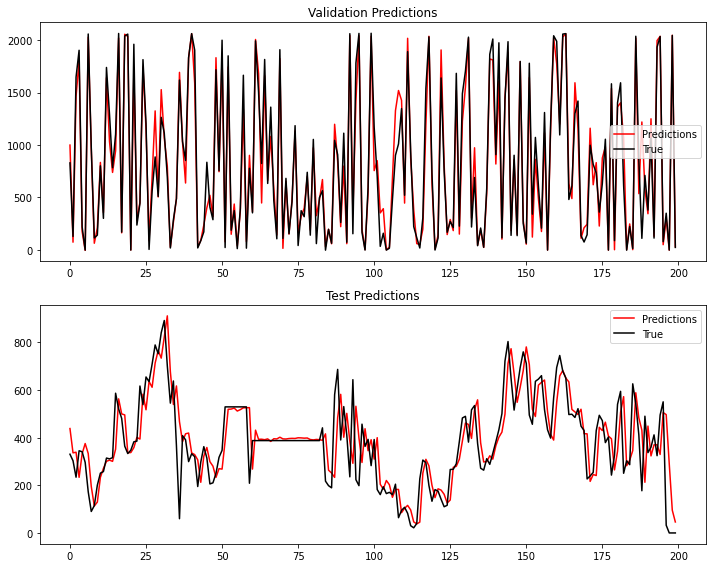

In [15]:
next_step_os_feat_hy,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)



## Next Hour Prediction



### Default

In [16]:
horizon = 6
window = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                              window, horizon,target_col = 'Power (kW)',test_split= 0.5)

In [17]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.095738
0:	learn: 618.3277990	test: 573.2941751	best: 573.2941751 (0)	total: 6.2ms	remaining: 6.2s
500:	learn: 212.7916141	test: 287.2964926	best: 265.1629761 (49)	total: 2.49s	remaining: 2.48s
999:	learn: 186.9079140	test: 297.3709728	best: 265.1629761 (49)	total: 4.96s	remaining: 0us
bestTest = 265.1629761
bestIteration = 49
Shrink model to first 50 iterations.


                   MAE        RMSE        R2
Validation  183.617098  265.162979  0.813420
Test        185.392728  266.246002  0.850659


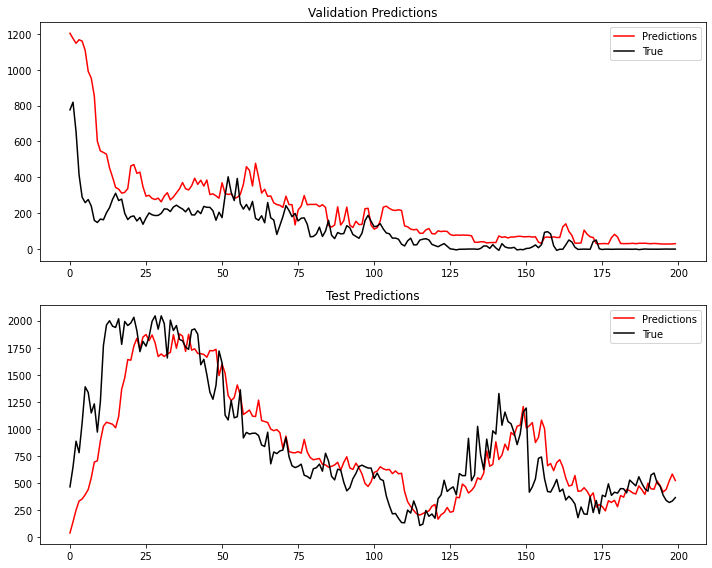

In [18]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [19]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]


In [20]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1])

Learning rate set to 0.095738
0:	learn: 618.2715985	test: 572.9940784	best: 572.9940784 (0)	total: 3.71ms	remaining: 3.7s
500:	learn: 216.5676284	test: 265.0265207	best: 263.1225261 (204)	total: 1.45s	remaining: 1.45s
999:	learn: 193.8076418	test: 268.1031313	best: 263.1225261 (204)	total: 2.94s	remaining: 0us
bestTest = 263.1225261
bestIteration = 204
Shrink model to first 205 iterations.


                   MAE        RMSE        R2
Validation  181.331109  263.122530  0.816281
Test        183.708080  265.459421  0.851540


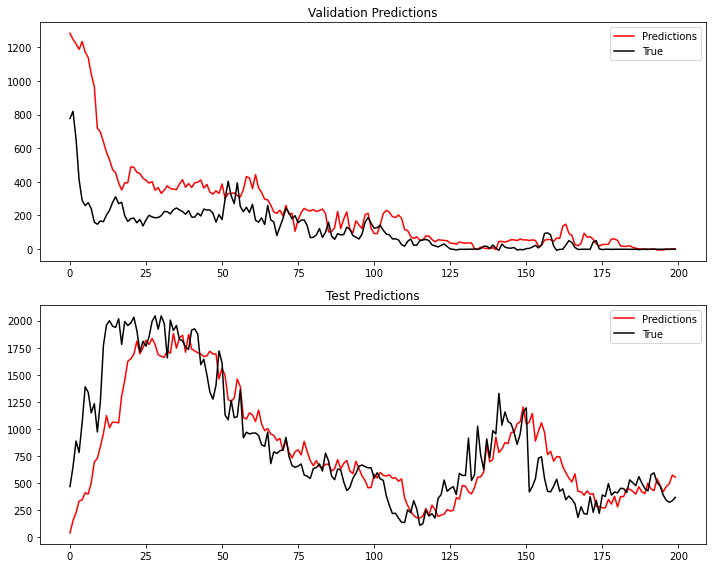

In [21]:
next_hour_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [22]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-02 21:31:09,280] A new study created in memory with name: no-name-8be3903e-cbaf-48cc-a599-c2786820a5ad
[I 2023-09-02 21:31:17,250] Trial 0 finished with value: 182.22476907323025 and parameters: {'learning_rate': 0.004995661531111698, 'depth': 9, 'min_data_in_leaf': 28}. Best is trial 0 with value: 182.22476907323025.
[I 2023-09-02 21:31:25,151] Trial 1 finished with value: 276.1685199295099 and parameters: {'learning_rate': 0.0010422719346023582, 'depth': 9, 'min_data_in_leaf': 53}. Best is trial 0 with value: 182.22476907323025.
[I 2023-09-02 21:31:30,766] Trial 2 finished with value: 222.55234266848356 and parameters: {'learning_rate': 0.0017220529756764424, 'depth': 8, 'min_data_in_leaf': 75}. Best is trial 0 with value: 182.22476907323025.
[I 2023-09-02 21:31:32,501] Trial 3 finished with value: 292.3426204698025 and parameters: {'learning_rate': 0.0010314769643947014, 'depth': 2, 'min_data_in_leaf': 68}. Best is trial 0 with value: 182.22476907323025.
[I 2023-09-02 21:

Best hyperparameters: {'learning_rate': 0.01295853204616923, 'depth': 6, 'min_data_in_leaf': 70}
Best RMSE: 180.33169438811234


({'learning_rate': 0.01295853204616923, 'depth': 6, 'min_data_in_leaf': 70},
 180.33169438811234)

                   MAE        RMSE        R2
Validation  184.316509  263.439767  0.815837
Test        187.377119  265.734267  0.851233


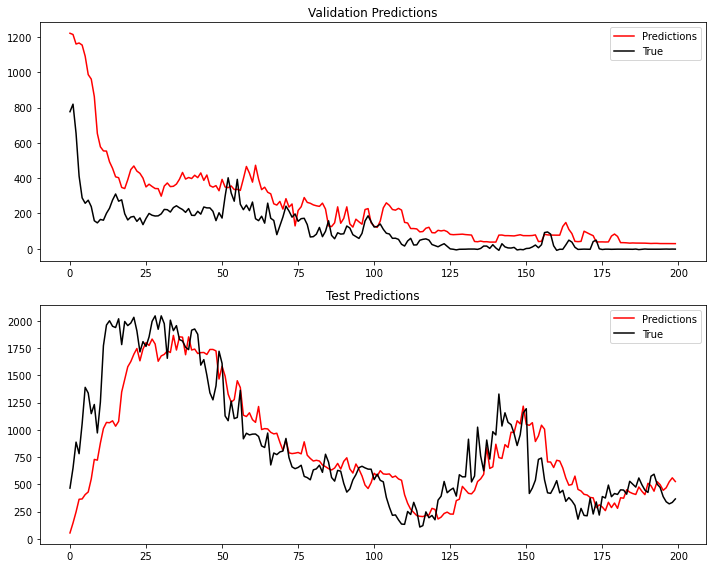

In [23]:
next_hour_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)



## Next Day Prediction



### Default

In [24]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5)

In [25]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.095713
0:	learn: 651.1039076	test: 615.6136845	best: 615.6136845 (0)	total: 6.14ms	remaining: 6.13s
500:	learn: 315.4195207	test: 653.1212459	best: 580.3027104 (29)	total: 2.45s	remaining: 2.44s
999:	learn: 251.2988255	test: 706.5186945	best: 580.3027104 (29)	total: 4.92s	remaining: 0us
bestTest = 580.3027104
bestIteration = 29
Shrink model to first 30 iterations.


                   MAE        RMSE        R2
Validation  470.057171  580.302700  0.107623
Test        529.302672  640.388797  0.136180


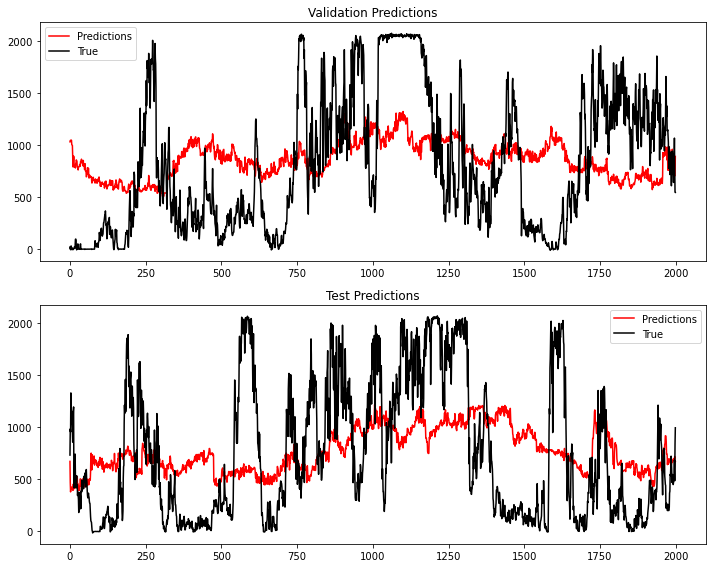

In [26]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [27]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [28]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.095713
0:	learn: 652.6985115	test: 607.6714732	best: 607.6714732 (0)	total: 4.57ms	remaining: 4.57s
500:	learn: 376.8222756	test: 606.2925197	best: 553.3291506 (21)	total: 1.47s	remaining: 1.47s
999:	learn: 317.7113786	test: 624.1494747	best: 553.3291506 (21)	total: 2.91s	remaining: 0us
bestTest = 553.3291506
bestIteration = 21
Shrink model to first 22 iterations.


                   MAE        RMSE        R2
Validation  449.251419  553.329176  0.188654
Test        517.556531  625.241740  0.176561


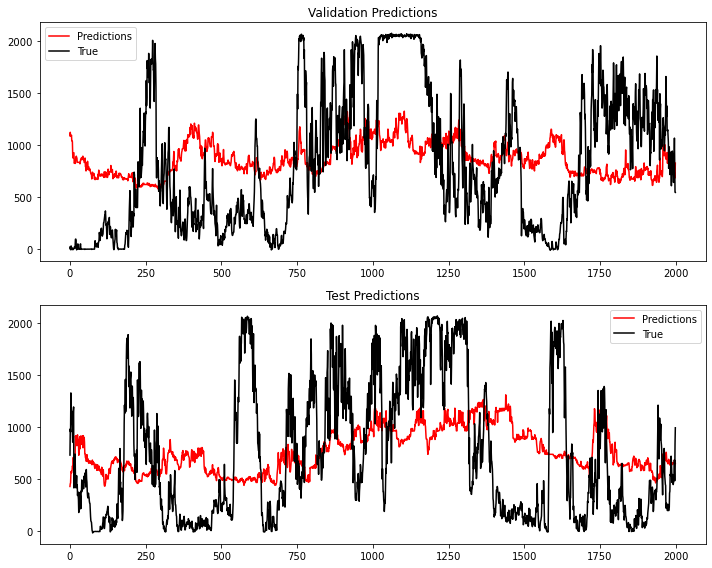

In [29]:
next_day_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [30]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-02 21:34:27,282] A new study created in memory with name: no-name-b79c6574-f1a3-4f92-aa65-da8eef666b9b
[I 2023-09-02 21:34:28,532] Trial 0 finished with value: 451.7009306389623 and parameters: {'learning_rate': 0.004674993093749098, 'depth': 1, 'min_data_in_leaf': 68}. Best is trial 0 with value: 451.7009306389623.
[I 2023-09-02 21:34:40,690] Trial 1 finished with value: 461.39677998579225 and parameters: {'learning_rate': 0.0013083566537653015, 'depth': 10, 'min_data_in_leaf': 78}. Best is trial 0 with value: 451.7009306389623.
[I 2023-09-02 21:34:44,011] Trial 2 finished with value: 448.810651294915 and parameters: {'learning_rate': 0.0024650318888700382, 'depth': 6, 'min_data_in_leaf': 51}. Best is trial 2 with value: 448.810651294915.
[I 2023-09-02 21:34:46,421] Trial 3 finished with value: 464.48440855703836 and parameters: {'learning_rate': 0.0010852872279175224, 'depth': 4, 'min_data_in_leaf': 19}. Best is trial 2 with value: 448.810651294915.
[I 2023-09-02 21:34:50,

Best hyperparameters: {'learning_rate': 0.0289836229349701, 'depth': 2, 'min_data_in_leaf': 62}
Best RMSE: 442.1612847061307


({'learning_rate': 0.0289836229349701, 'depth': 2, 'min_data_in_leaf': 62},
 442.1612847061307)

                   MAE        RMSE        R2
Validation  442.695575  552.043862  0.192419
Test        511.017119  621.118054  0.187387


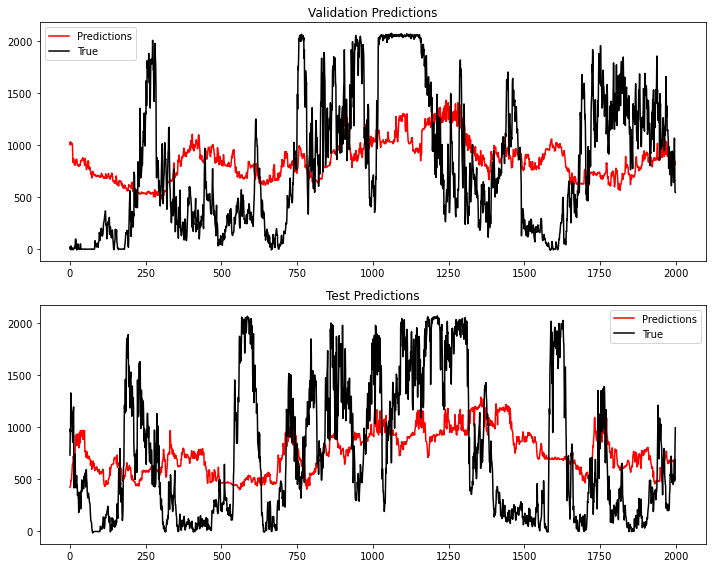

In [31]:
next_day_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns)

# Recursive Modelling

## Next Hour Prediction

In [32]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 6,target_col ='Power (kW)',test_split = 0.5,univariate= True)

In [33]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.04564318003506682, 'depth': 9, 'min_data_in_leaf': 28},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

0:	learn: 642.1142728	test: 593.3453715	best: 593.3453715 (0)	total: 17.7ms	remaining: 17.7s


500:	learn: 129.8959739	test: 153.6287495	best: 153.3346002 (210)	total: 7.75s	remaining: 7.72s
999:	learn: 113.3924338	test: 154.0719564	best: 153.3346002 (210)	total: 15.6s	remaining: 0us
bestTest = 153.3346002
bestIteration = 210
Shrink model to first 211 iterations.


                   MAE        RMSE        R2
Validation  110.286997  164.338395  0.928329
Test        109.093834  161.195173  0.945257


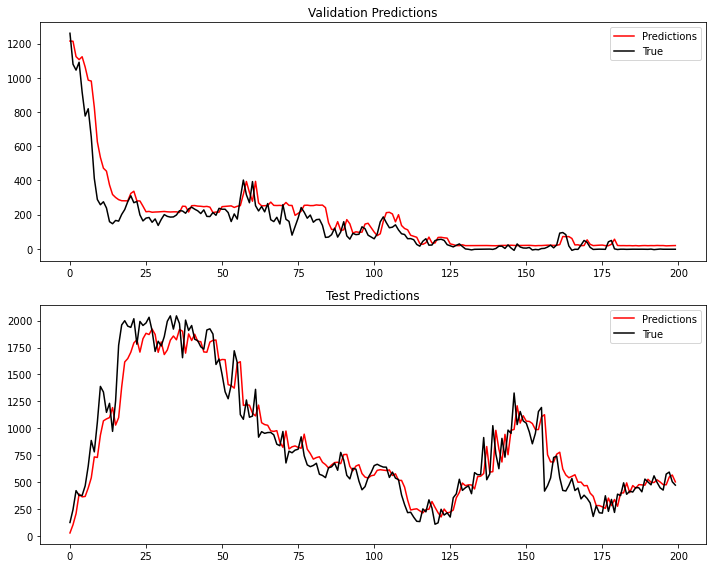

In [34]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

## Next Day Prediction

In [35]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5,univariate=True)

In [36]:

model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.04564318003506682, 'depth': 9, 'min_data_in_leaf': 28},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

0:	learn: 642.3479671	test: 593.7040349	best: 593.7040349 (0)	total: 16.9ms	remaining: 16.9s
500:	learn: 129.7764977	test: 153.4063148	best: 153.3109950 (354)	total: 7.75s	remaining: 7.72s
999:	learn: 113.1048174	test: 153.7299259	best: 153.3109950 (354)	total: 15.6s	remaining: 0us
bestTest = 153.310995
bestIteration = 354
Shrink model to first 355 iterations.


                   MAE        RMSE        R2
Validation  159.266859  243.428880  0.843102
Test        179.771090  268.862061  0.847740


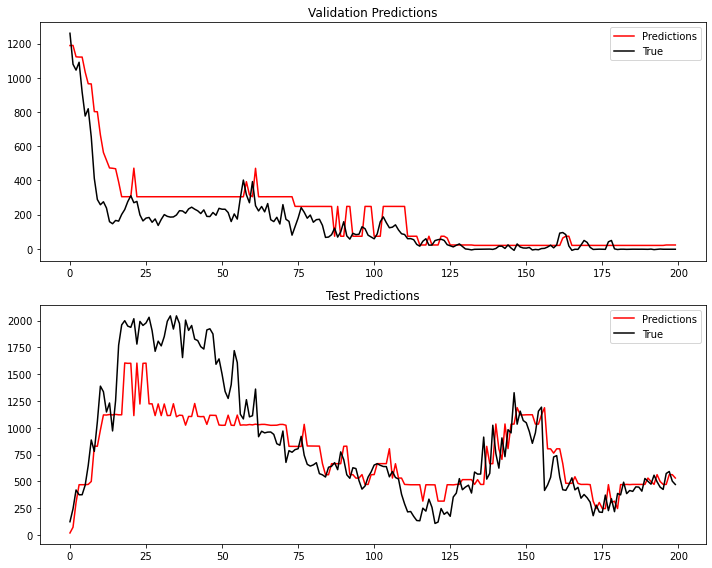

In [37]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [74]:
next_step_baseline = {'MAE': 91.554 , 'RMSE': 145.603, 'R2':0 }
results = [next_step_baseline,next_step_os.iloc[1,:],next_step_os_feat.iloc[1,:],next_step_os_feat_hy.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op']

experiment_results(names, results,title = 'Next Step Prediction')

| Metric                 | MAE       | RMSE        | R2        |
|:-----------------------|:----------|:------------|:----------|
| Next Step Prediction   |           |             |           |
| Baseline               | 91.554    | 145.603     | -         |
| One Shot               | 90.5      | 140.675     | 0.956     |
| One Shot Feat          | 89.796    | 140.099     | 0.956     |
| One Shot Feat + Hyp-op | **89.45** | **139.521** | **0.957** |


In [39]:
next_hour_baseline = {'MAE': 183.286 , 'RMSE': 263.749	, 'R2':0 }	
results = [next_hour_baseline,next_hour_os.iloc[1,:],next_hour_os_feat.iloc[1,:],next_hour_os_feat_hy.iloc[1,:],next_hour_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Hour Prediction')

| Metric                 | MAE         | RMSE        | R2        |
|:-----------------------|:------------|:------------|:----------|
| Next Hour Prediction   |             |             |           |
| Baseline               | 183.286     | 263.749     | -         |
| One Shot               | 185.393     | 266.246     | 0.851     |
| One Shot Feat          | 183.708     | 265.459     | 0.852     |
| One Shot Feat + Hyp-op | 187.377     | 265.734     | 0.851     |
| Recursive              | **109.094** | **161.195** | **0.945** |


In [41]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }	
results = [next_day_baseline,next_day_os.iloc[1,:],next_day_os_feat.iloc[1,:],next_day_os_feat_hy.iloc[1,:], next_day_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Day Prediction')

| Metric                 | MAE         | RMSE        | R2        |
|:-----------------------|:------------|:------------|:----------|
| Next Day Prediction    |             |             |           |
| Baseline               | 510.71      | 623.023     | -         |
| One Shot               | 529.303     | 640.389     | 0.136     |
| One Shot Feat          | 517.557     | 625.242     | 0.177     |
| One Shot Feat + Hyp-op | 511.017     | 621.118     | 0.187     |
| Recursive              | **179.771** | **268.862** | **0.848** |
